In [1]:
# import Libraries
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import math
import datetime
import time

from sqlalchemy import create_engine
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Objective:

As an emerging investor, I am looking to invest in the stock market at a precise time. I am attempting to time the market in search of opportunities to buy low and sell high. However, there are many stocks to choose from. 
I need to filter through the stock to find the group of performing stocks at a specific time of the year (i.e. 31 of december).
In this project, I will attempt to use the K-means clustering algorithm to identify some performing stocks.




## Data Collection

Data pulled and stored to a database

In [2]:
# Connect to Database to retrieve data  and load the data from database to dataframe
database_name = "../data/CompanyData.sqlite"
engine = create_engine(f"sqlite:///{database_name}", echo=False)
master_df = pd.read_sql_query("SELECT * FROM MasterData", engine)
master_df = master_df.dropna()
master_df.head()

,monthend_date,ticker,price,wealth_index,end_wealth_index,total_return,cash,st_debt,lt_debt,equity,...,market_cap,net_debt,net_debt_capital,enterprise_value,ev_revenue,revenue_ev,ev_ebit,ebit_ev,name,sector
0,2014-12-31,A,40.94,39.0850,36.1469,-7.517206,2.218000e+09,0.0,1.663000e+09,5.301000e+09,...,1.362185e+10,-555000000.0,-11.694058,1.306685e+10,3.227978,0.309791,31.185810,0.032066,Agilent Technologies Inc,Health Care
1,2015-01-31,A,37.77,36.1469,40.3961,11.755365,2.218000e+09,0.0,1.663000e+09,5.301000e+09,...,1.256711e+10,-555000000.0,-11.694058,1.201211e+10,2.967418,0.336993,28.668518,0.034881,Agilent Technologies Inc,Health Care
2,2015-02-28,A,42.21,40.3961,39.8624,-1.321167,2.218000e+09,0.0,1.663000e+09,5.301000e+09,...,1.404442e+10,-555000000.0,-11.694058,1.348942e+10,3.332366,0.300087,32.194315,0.031061,Agilent Technologies Inc,Health Care
3,2015-03-31,A,41.55,39.8624,39.6897,-0.433240,2.118000e+09,0.0,1.658000e+09,4.237000e+09,...,1.386108e+10,-460000000.0,-12.178978,1.340108e+10,3.295888,0.303408,32.685561,0.030595,Agilent Technologies Inc,Health Care
4,2015-04-30,A,41.37,39.6897,39.5170,-0.435125,2.118000e+09,0.0,1.658000e+09,4.237000e+09,...,1.380103e+10,-460000000.0,-12.178978,1.334103e+10,3.281120,0.304774,32.539102,0.030732,Agilent Technologies Inc,Health Care


## Data Transformation
Using the last monthend of the last 5 years 2014 - 2018, to see how stock performed by the end of each year within each cluster.

In [3]:
# Query database for needed data in dec 31 of 2014 -2018 plus 2019/03
# Create a list of the possible criteria

df_date_m = pd.read_sql_query('SELECT monthend_date, ticker, earnings_yield, book_yield, net_debt_capital, revenue_ev, ebit_ev, total_return, sector FROM MasterData WHERE monthend_date LIKE "%-12-31" ', engine)
df_date_m = df_date_m.dropna()
df_date_m.head(10)

,monthend_date,ticker,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return,sector
0,2014-12-31,A,3.957010,38.915406,-11.694058,0.309791,0.032066,-7.517206,Health Care
1,2015-12-31,A,2.870127,29.824983,-9.112333,0.296399,0.038316,-9.949974,Health Care
2,2016-12-31,A,3.072871,28.624353,-9.979264,0.291037,0.042596,7.484568,Health Care
3,2017-12-31,A,3.135732,22.358183,-16.018252,0.213559,0.040162,9.646140,Health Care
4,2018-12-31,A,1.437889,20.995377,-10.876426,0.230656,0.043559,12.733403,Health Care
5,2014-12-31,AAL,-7.626329,-131.855725,76.195949,3.282663,0.288586,-8.484063,Industrials
6,2015-12-31,AAL,16.528926,12.965816,83.858927,0.855029,0.123477,-7.933933,Industrials
7,2016-12-31,AAL,19.490255,15.397765,83.946916,0.777422,0.108491,-5.225878,Industrials
8,2017-12-31,AAL,8.091486,15.565928,86.045525,0.840162,0.083187,4.401314,Industrials
9,2018-12-31,AAL,3.706011,-4.119401,102.376967,1.155849,0.071812,11.398364,Industrials


In [4]:
# Drop the following columns: "monthend_date", "ticker"
df_date= df_date_m.copy()
df_date= df_date.drop(columns=["monthend_date", "ticker"])
df_date.head(10)

,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return,sector
0,3.957010,38.915406,-11.694058,0.309791,0.032066,-7.517206,Health Care
1,2.870127,29.824983,-9.112333,0.296399,0.038316,-9.949974,Health Care
2,3.072871,28.624353,-9.979264,0.291037,0.042596,7.484568,Health Care
3,3.135732,22.358183,-16.018252,0.213559,0.040162,9.646140,Health Care
4,1.437889,20.995377,-10.876426,0.230656,0.043559,12.733403,Health Care
5,-7.626329,-131.855725,76.195949,3.282663,0.288586,-8.484063,Industrials
6,16.528926,12.965816,83.858927,0.855029,0.123477,-7.933933,Industrials
7,19.490255,15.397765,83.946916,0.777422,0.108491,-5.225878,Industrials
8,8.091486,15.565928,86.045525,0.840162,0.083187,4.401314,Industrials
9,3.706011,-4.119401,102.376967,1.155849,0.071812,11.398364,Industrials


In [5]:
# check for null values
df_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2390 entries, 0 to 2401
Data columns (total 7 columns):
earnings_yield      2390 non-null float64
book_yield          2390 non-null float64
net_debt_capital    2390 non-null float64
revenue_ev          2390 non-null float64
ebit_ev             2390 non-null float64
total_return        2390 non-null float64
sector              2390 non-null object
dtypes: float64(6), object(1)
memory usage: 149.4+ KB


In [6]:
# Get dummy value(binary) for sector
df_datedummy = pd.get_dummies(df_date)
df_datedummy.head()

,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities
0,3.957010,38.915406,-11.694058,0.309791,0.032066,-7.517206,0,0,0,0,0,1,0,0,0,0,0
1,2.870127,29.824983,-9.112333,0.296399,0.038316,-9.949974,0,0,0,0,0,1,0,0,0,0,0
2,3.072871,28.624353,-9.979264,0.291037,0.042596,7.484568,0,0,0,0,0,1,0,0,0,0,0
3,3.135732,22.358183,-16.018252,0.213559,0.040162,9.646140,0,0,0,0,0,1,0,0,0,0,0
4,1.437889,20.995377,-10.876426,0.230656,0.043559,12.733403,0,0,0,0,0,1,0,0,0,0,0


In [7]:
# Retrieve the statistic for 2014-12-31
df_datedummy.describe()

,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities
count,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000
mean,4.133749,35.711051,47.229672,0.477021,0.046721,2.012220,0.043933,0.126360,0.065272,0.056485,0.135983,0.126778,0.139331,0.135146,0.046862,0.066946,0.056904
std,7.491764,34.536278,534.376365,0.668814,0.052618,9.136137,0.204989,0.332324,0.247057,0.230905,0.342843,0.332794,0.346364,0.341951,0.211387,0.249980,0.231707
min,-155.096012,-445.682110,-1815.391598,-6.703433,-0.723956,-34.937759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.777071,15.203465,15.214355,0.193212,0.026658,-3.476890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.378943,28.799904,36.500587,0.309697,0.050282,2.260125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.101015,49.048001,54.818622,0.542928,0.069662,7.557452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,36.274819,266.486903,25379.490053,9.135323,0.432317,40.810586,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Data Processing
# Extract the criteria for the scaling
df_date = df_datedummy.iloc[ : , 0:6]
df_date.head()

,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return
0,3.957010,38.915406,-11.694058,0.309791,0.032066,-7.517206
1,2.870127,29.824983,-9.112333,0.296399,0.038316,-9.949974
2,3.072871,28.624353,-9.979264,0.291037,0.042596,7.484568
3,3.135732,22.358183,-16.018252,0.213559,0.040162,9.646140
4,1.437889,20.995377,-10.876426,0.230656,0.043559,12.733403


In [9]:
# Rename the sector
dummy_sector =df_datedummy.iloc[ : , 6:]
dummy_sector = dummy_sector.rename(columns = {'sector_Communication Services':6, 'sector_Consumer Discretionary':7, 'sector_Consumer Staples':8, 'sector_Energy': 9, 'sector_Financials': 10, 'sector_Health Care': 11, 'sector_Industrials': 12, 'sector_Information Technology':13, 'sector_Materials':14,  'sector_Real Estate': 15, 'sector_Utilities':16 })

## Standardized the data

In [10]:
# standardized the data
scaler = StandardScaler()
scaled = scaler.fit_transform(df_date)

# statistics of scaled data
scaled_data = pd.DataFrame(scaled)

In [11]:
# X is the train_data
X = pd.concat([scaled_data, dummy_sector ], axis=1)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.023596,0.092802,-0.110289,-0.250091,-0.278573,-1.043266,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.168703,-0.170467,-0.105457,-0.270119,-0.159762,-1.309601,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.141636,-0.205239,-0.107080,-0.278139,-0.078410,0.599104,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.133243,-0.386714,-0.118383,-0.394006,-0.124678,0.835749,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.359918,-0.426182,-0.108759,-0.368437,-0.060099,1.173738,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# change nan value to number
X = np.nan_to_num(X)
X

array([[-0.02359601,  0.09280171, -0.11028942, ...,  0.        ,
         0.        ,  0.        ],
       [-0.16870348, -0.17046711, -0.10545713, ...,  0.        ,
         0.        ,  0.        ],
       [-0.14163554, -0.20523869, -0.10707979, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Select Algorithm - K-means Clustering

#### How K-means Clustering work

* Step 1: Determine K value by Elbow method and specify the number of clusters K
* Step 2: Randomly assign each data point to a cluster
* Step 3: Determine the cluster centroid coordinates
* Step 4: Determine the distances of each data point to the centroids and re-assign each point to the closest cluster centroid based upon minimum distance
* Step 5: Calculate cluster centroids again
* Step 6: Repeat steps 4 and 5 until we reach global optima where no improvements are possible and no switching of data points from one cluster to other.

## Find the optimum number of clusters for k-means clustering

Text(0, 0.5, 'Score')

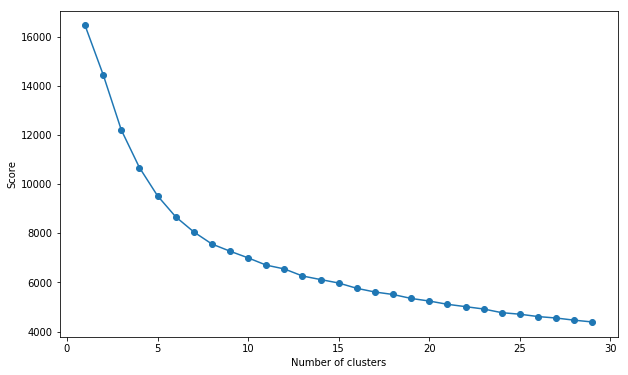

In [13]:
# Draw elbow plot and figure out the optimal value of k
# fitting multiple k-means algorithms and storing the values in an empty list

score = []

for cluster in range(1,30):

    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(X)
    score.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,30), 'score':score})

plt.figure(figsize=(10,6))
plt.plot(frame['Cluster'], frame['score'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')


# Train the model

In [14]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=2, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
#Implementation of K-Means Clustering
# k means using specific clusters and k-means++ initialization

kmeans = KMeans(n_clusters = 8, init='k-means++',n_jobs = -1,)
kmeans.fit(X)





KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Prediction

In [16]:
# labels = kmeans.labels_
predicted_clusters = kmeans.predict(X)

In [17]:
# Print the cluster centers and cluster labels
centers = kmeans.cluster_centers_


In [18]:
# Add column names for cluster, monthend_date, ticker and sector
monthend_date = df_date_m['monthend_date']
sector = df_date_m['sector']
ticker = df_date_m['ticker']

frame = pd.DataFrame(X)

frame['cluster'] = predicted_clusters
frame['monthend_date'] = monthend_date
frame['ticker'] = ticker


frame['sector'] = sector
frame = frame.drop(columns=[6])
frame.head()

,0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,cluster,monthend_date,ticker,sector
0,-0.023596,0.092802,-0.110289,-0.250091,-0.278573,-1.043266,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,2014-12-31,A,Health Care
1,-0.168703,-0.170467,-0.105457,-0.270119,-0.159762,-1.309601,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,2015-12-31,A,Health Care
2,-0.141636,-0.205239,-0.107080,-0.278139,-0.078410,0.599104,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6,2016-12-31,A,Health Care
3,-0.133243,-0.386714,-0.118383,-0.394006,-0.124678,0.835749,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6,2017-12-31,A,Health Care
4,-0.359918,-0.426182,-0.108759,-0.368437,-0.060099,1.173738,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6,2018-12-31,A,Health Care


In [19]:
# Rename the new dataframe columns accordingly
frame = frame.rename(columns = {0:'earnings_yield', 1:'book_yield', 2:'net_debt_capital', 3:'revenue_ev',  4:'ebit_ev', 5:'total_return'})


In [20]:
# Re-arrange columns of dataframe
frame = frame[['monthend_date', 'earnings_yield', 'book_yield','net_debt_capital', 'revenue_ev','ebit_ev', 'total_return', 'cluster','ticker', 'sector']]
frame=frame.dropna()
frame.head(20)

framegroup = frame.groupby(['monthend_date', 'ticker',]) 
framegroup.first()

earnings_yield  book_yield  net_debt_capital  \
monthend_date ticker                                                 
2014-12-31    A            -0.023596    0.092802         -0.110289   
              AAL          -1.570063   -4.852921          0.054217   
              AAP          -0.029692   -0.554865         -0.002137   
              AAPL          0.228258   -0.553481         -0.058212   
              ABBV         -0.082652   -0.906305          0.024577   
              ABC          -0.380117   -0.756874         -0.072066   
              ABMD         -0.464192   -0.691907         -0.109105   
              ABT          -0.175266   -0.077078         -0.056581   
              ACN           0.123798   -0.741026         -1.182339   
              ADI          -0.075761   -0.241538         -0.077176   
              ADM           0.195243    0.683923         -0.079566   
              ADP          -0.055457   -0.610940         -0.096016   
              ADS          -0.142567   -0.830319          0.073020   
              ADSK         -0.434074   -0.549826         -0.155405   
              AEE           0.220854    0.767504          0.005670   
              AEP           0.307822    0.781187          0.017526   
              AES          -0.067110    0.260976          0.064182   
              AFL           0.842416    0.824696         -0.070466   
              AGN          -0.815885    0.561175         -0.021872   
              AIG           0.887832    2.841051         -0.043478   
              AIV           0.590925   -0.245549         -0.092957   
              AIZ           0.852842    2.076025         -0.097215   
              AJG           0.049294    0.333583         -0.014365   
              AKAM         -0.180797   -0.298958         -0.066076   
              ALB           0.289613   -0.165625         -0.048137   
              ALGN         -0.119677   -0.571202         -0.150821   
              ALK           0.357377    0.525883         -0.035097   
              ALL           0.618800    1.052882         -0.058118   
              ALLE         -0.178759   -1.050849          0.104533   
              ALXN         -0.378717   -0.789109         -0.132512   
...                              ...         ...               ...   
2018-12-31    VRTX          0.199000   -0.194180         -0.067996   
              VTR           0.003651   -0.524210         -0.018602   
              VZ            0.075241   -0.026935         -0.037966   
              WAB          -0.116592    0.405735         -0.114676   
              WAT           0.699818    0.912929         -0.158546   
              WBA           0.051773    0.939009          0.011501   
              WCG          -0.075004    1.651785         -0.006243   
              WDC           0.464894    0.961119          0.018295   
              WEC           0.225325    0.182655         -0.002623   
              WELL          1.347513    1.077442         -0.008511   
              WFC           0.028472   -0.415636          0.029632   
              WHR          -0.344094   -0.046179          0.054133   
              WLTW          0.465211    0.131991         -0.020336   
              WM            0.558814   -0.683209          0.030336   
              WMB           0.526888   -0.205356         -0.021321   
              WMT           0.184039   -1.015927          0.094872   
              WRK          -0.138957   -1.107428          0.103733   
              WU           -3.252516    0.160179         -0.055832   
              WY            0.161938    0.645981          0.014254   
              WYNN          0.056387   -0.417837         -0.043720   
              XEC           0.259949    0.473570         -0.056151   
              XEL          -0.126243   -0.259650         -0.034645   
              XLNX          0.091876   -0.138135         -0.042490   
              XOM           0.135298   -1.682618          0.510054   
              XRAY         -0.42

In [21]:
# Save dataframe with column: cluster, ticker, total_return and sector to a file 
cluster_return = frame[['cluster', 'ticker', 'total_return',  'sector']].set_index("cluster")
cluster_return.to_csv('Output/cluster_return.csv')

### Question 1 Average Return for each cluster

In [22]:
# Question 1 Average Return for each cluster

cluster_performance = frame.groupby(['monthend_date',  'cluster', ]).agg({'total_return':'mean', 'ticker':'count' })
cluster_performance.rename(columns = {'total_return':'avg_return'})

avg_return  ticker
monthend_date cluster                    
2014-12-31    0          0.044741      10
              1         -0.171160      56
              2         -0.654319     161
              4          0.360709       8
              5         -0.261096      58
              6          0.613880     171
2015-12-31    0          0.161631       4
              1          0.196032      51
              2         -0.754626     145
              3          0.368568       1
              4          0.408192       6
              5          0.079453      59
              6          0.676601     210
2016-12-31    0          0.623531       6
              1          0.561315      60
              2         -0.542315     103
              4          1.026849       6
              5          0.371766      62
              6          0.920263     241
              7          2.079047       2
2017-12-31    0         -0.137589       4
              1         -0.510557      55
              2         -0.751094     212
              4         -0.605876       8
              5         -0.384715      55
              6          0.712059     148
              7          2.628617       1
2018-12-31    0          0.003739       6
              1         -0.420116      54
              2         -0.998339     212
              4         -0.541835       7
              5         -0.264443      58
              6          0.661435     147
              7         -1.343286       3

### Question 2

### Which ticker is in each cluster

In [23]:
# Extract each ticker and sector in each cluster
flag=True

for i in range(0,7):
   
    cluster_group = frame.loc[frame["cluster"] ==i]["ticker"]

    cluster_sector = frame.loc[frame["cluster"] ==i]["sector"]
   
    cluster_tickergroup=pd.concat([cluster_group, cluster_sector], axis=1)
    cluster_tickergroup["cluster"]=i
    if flag==True:
        clusterlist=cluster_tickergroup
        flag=False
    else:
        clusterlist=pd.concat([clusterlist, cluster_tickergroup])
clusterlist=clusterlist.set_index("cluster")
clusterlist.head()

,ticker,sector
cluster,,
0,AGN,Health Care
0,AMD,Information Technology
0,COP,Energy
0,CXO,Energy
0,DVN,Energy


### Question 3 
#### Enter a ticker to find the cluster it belong to and check if it changes it cluster over time.

In [24]:
# Enter a ticker to find the cluster it belong
ticker_request = (input("Enter the ticker to find a cluster it belong?:").upper())
ticker_request 

Enter the ticker to find a cluster it belong?:aapl


'AAPL'

In [25]:
# Print cluster information
frame.loc[frame['ticker'] == ticker_request, ['monthend_date', 'ticker','cluster', 'total_return', 'sector']]

,monthend_date,ticker,cluster,total_return,sector
15,2014-12-31,AAPL,6,0.452169,Information Technology
16,2015-12-31,AAPL,2,-1.044041,Information Technology
17,2016-12-31,AAPL,6,0.302430,Information Technology
18,2017-12-31,AAPL,2,-0.336742,Information Technology
19,2018-12-31,AAPL,6,0.383526,Information Technology


In [26]:
# It looks like the ticker changes cluster in some years

In [27]:
#===========================================================================================================================

### Assumming, I am working with year 2014-12-31 only, what patterns will I see

In [28]:
# Query databse for specific data in 2014-12-31

df_2014_m = pd.read_sql_query('SELECT monthend_date, ticker, earnings_yield, book_yield, net_debt_capital, revenue_ev, ebit_ev, total_return, sector FROM MasterData WHERE monthend_date="2014-12-31" AND NOT earnings_yield = "0" ', engine)
df_2014_m = df_2014_m.dropna()
df_2014_m.head()

,monthend_date,ticker,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return,sector
0,2014-12-31,A,3.957010,38.915406,-11.694058,0.309791,0.032066,-7.517206,Health Care
1,2014-12-31,AAL,-7.626329,-131.855725,76.195949,3.282663,0.288586,-8.484063,Industrials
2,2014-12-31,AAP,3.911351,16.552086,46.088087,0.678925,0.059980,-0.175748,Consumer Discretionary
3,2014-12-31,AAPL,5.843450,16.599889,16.128814,0.263612,0.075715,6.142435,Information Technology
4,2014-12-31,ABBV,3.514670,4.417194,60.360130,0.174810,0.047768,-7.085789,Health Care


In [29]:
# Make a copy of the dataframe
df_2014 = df_2014_m.copy()
df_2014 = df_2014.drop(columns=["monthend_date", "ticker",])

In [30]:
# Get dummy value(binary) for sector
df_2014dummy = pd.get_dummies(df_2014)
df_2014dummy.head()

,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities
0,3.957010,38.915406,-11.694058,0.309791,0.032066,-7.517206,0,0,0,0,0,1,0,0,0,0,0
1,-7.626329,-131.855725,76.195949,3.282663,0.288586,-8.484063,0,0,0,0,0,0,1,0,0,0,0
2,3.911351,16.552086,46.088087,0.678925,0.059980,-0.175748,0,1,0,0,0,0,0,0,0,0,0
3,5.843450,16.599889,16.128814,0.263612,0.075715,6.142435,0,0,0,0,0,0,0,1,0,0,0
4,3.514670,4.417194,60.360130,0.174810,0.047768,-7.085789,0,0,0,0,0,1,0,0,0,0,0


In [31]:
# Retrieve the statistic for 2014-12-31
df_2014dummy.describe()

,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities
count,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000
mean,4.608727,35.078201,23.970915,0.494227,0.053735,-1.723477,0.045356,0.125270,0.062635,0.056156,0.138229,0.129590,0.140389,0.129590,0.045356,0.069114,0.058315
std,3.254615,29.535471,102.410749,0.610192,0.037993,7.291320,0.208310,0.331383,0.242567,0.230471,0.345513,0.336215,0.347766,0.336215,0.208310,0.253923,0.234592
min,-9.972426,-131.855725,-1815.391598,-1.499539,-0.108998,-27.049938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.141542,16.281141,9.798882,0.199438,0.031083,-6.401576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.439989,28.517004,32.929205,0.330965,0.056122,-2.161696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.882592,47.808729,52.642627,0.568449,0.072858,2.762537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,23.378736,189.262121,289.863198,5.798513,0.288586,35.943248,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
# Data Processing
# Extract the criteria for the scaling
df_2014 = df_2014dummy.iloc[ : , 0:6]
df_2014.head()

,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return
0,3.957010,38.915406,-11.694058,0.309791,0.032066,-7.517206
1,-7.626329,-131.855725,76.195949,3.282663,0.288586,-8.484063
2,3.911351,16.552086,46.088087,0.678925,0.059980,-0.175748
3,5.843450,16.599889,16.128814,0.263612,0.075715,6.142435
4,3.514670,4.417194,60.360130,0.174810,0.047768,-7.085789


In [33]:
## standardized the data

In [34]:
# standardized the data
scaler = StandardScaler()

scaled_2014 = scaler.fit_transform(df_2014)

# statistics of scaled data
scaled_data2014 = pd.DataFrame(scaled_2014)

In [35]:
# Rename the sector binary values
dummy_sector = df_2014dummy.iloc[ : , 6:]
dummy_sector = dummy_sector.rename(columns = {'sector_Communication Services':6, 'sector_Consumer Discretionary':7, 'sector_Consumer Staples':8, 'sector_Energy': 9, 'sector_Financials': 10, 'sector_Health Care': 11, 'sector_Industrials': 12, 'sector_Information Technology':13, 'sector_Materials':14,  'sector_Real Estate': 15, 'sector_Utilities':16 })


In [36]:
# Concatinate the scaledata and dummy_sector
train_data = pd.concat([scaled_data2014, dummy_sector ], axis=1)
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.200460,0.130059,-0.348631,-0.302585,-0.570971,-0.795466,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-3.763360,-5.658095,0.510508,4.574709,6.188079,-0.928213,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.214505,-0.627928,0.216199,0.303015,0.164540,0.212500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.379786,-0.626308,-0.076658,-0.378348,0.579152,1.079972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.336519,-1.039231,0.355710,-0.524035,-0.157239,-0.736233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Convert nan value to numbers
train_data = np.nan_to_num(train_data)

In [38]:
# Train the model

In [39]:
# defining the kmeans function with initialization as k-means++
kmeans_2014 = KMeans(n_clusters=2, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans_2014.fit(train_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [40]:
# k means using 8 clusters and k-means++ initialization

kmeans = KMeans(n_clusters=8)
kmeans.fit(train_data)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [41]:
# Prediction
# labels = kmeans.labels_
predicted_clusters = kmeans.predict(train_data)

In [42]:
# Print the cluster centers and cluster labels
centers = kmeans.cluster_centers_

In [43]:
# Add column names for cluster, monthend_date, ticker and sector
monthend_date = df_2014_m['monthend_date']
sector = df_2014_m['sector']
ticker = df_2014_m['ticker']

frame_2014 = pd.DataFrame(train_data)

frame_2014['cluster'] = predicted_clusters
frame_2014['monthend_date'] = monthend_date
frame_2014['ticker'] = ticker
frame_2014['sector'] = sector

frame_2014 = frame_2014.drop(columns=[6, 7,8,9,10,11,12,13,14,15,16])
frame_2014.head()

,0,1,2,3,4,5,cluster,monthend_date,ticker,sector
0,-0.200460,0.130059,-0.348631,-0.302585,-0.570971,-0.795466,7,2014-12-31,A,Health Care
1,-3.763360,-5.658095,0.510508,4.574709,6.188079,-0.928213,3,2014-12-31,AAL,Industrials
2,-0.214505,-0.627928,0.216199,0.303015,0.164540,0.212500,0,2014-12-31,AAP,Consumer Discretionary
3,0.379786,-0.626308,-0.076658,-0.378348,0.579152,1.079972,2,2014-12-31,AAPL,Information Technology
4,-0.336519,-1.039231,0.355710,-0.524035,-0.157239,-0.736233,7,2014-12-31,ABBV,Health Care


In [44]:
# Rename the new dataframe columns accordingly
frame_2014 = frame_2014.rename(columns = {0:'earnings_yield', 1:'book_yield', 2:'net_debt_capital', 3:'revenue_ev',  4:'ebit_ev', 5:'total_return' })


In [45]:
# Re-arrange columns of dataframe
frame_2014 = frame_2014[['monthend_date', 'earnings_yield', 'book_yield', 'net_debt_capital', 'revenue_ev','ebit_ev', 'total_return', 'cluster','ticker', 'sector']]
frame_2014.head(10) 

,monthend_date,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return,cluster,ticker,sector
0,2014-12-31,-0.200460,0.130059,-0.348631,-0.302585,-0.570971,-0.795466,7,A,Health Care
1,2014-12-31,-3.763360,-5.658095,0.510508,4.574709,6.188079,-0.928213,3,AAL,Industrials
2,2014-12-31,-0.214505,-0.627928,0.216199,0.303015,0.164540,0.212500,0,AAP,Consumer Discretionary
3,2014-12-31,0.379786,-0.626308,-0.076658,-0.378348,0.579152,1.079972,2,AAPL,Information Technology
4,2014-12-31,-0.336519,-1.039231,0.355710,-0.524035,-0.157239,-0.736233,7,ABBV,Health Care
5,2014-12-31,-1.021847,-0.864347,-0.149007,8.702213,-0.416522,0.981293,3,ABC,Health Care
6,2014-12-31,-1.215549,-0.788313,-0.342446,-0.590184,-1.219962,5.171556,1,ABMD,Health Care
7,2014-12-31,-0.549894,-0.068757,-0.068139,-0.369180,-0.561348,0.229590,7,ABT,Health Care
8,2014-12-31,0.139121,-0.845798,-5.947436,0.200204,0.774919,-0.575068,7,ACN,Information Technology
9,2014-12-31,-0.320644,-0.261231,-0.175694,-0.545094,-0.294843,-0.606637,7,ADI,Information Technology


In [46]:
# Save dataframe with column: cluster, ticker, total_return and sector to a file 
cluster2014return = frame_2014[['cluster', 'ticker', 'total_return',  'sector']].set_index("cluster")
cluster2014return.to_csv('Output/cluster2014return.csv')

In [47]:
# Question 1 Average Return of each cluster

cluster_performance2014 = frame_2014.groupby(['monthend_date',  'cluster', ]).agg({'total_return':'mean', 'ticker':'count' })

cluster_performance2014.rename(columns = {'total_return':'avg_return'})


avg_return  ticker
monthend_date cluster                    
2014-12-31    0         -0.469935     120
              1          1.468527      54
              2          0.760904      88
              3         -0.087463      17
              4         -1.954550       1
              5         -0.673908      33
              6         -0.947686      34
              7         -0.275111     116

In [48]:
# Extract each ticker and sector in each cluster
flag=True

for i in range(0,7):
   
    cluster_group = frame_2014.loc[frame_2014["cluster"] ==i]["ticker"]

    cluster_sector = frame_2014.loc[frame_2014["cluster"] ==i]["sector"]
   
    cluster_tickergroup=pd.concat([cluster_group, cluster_sector], axis=1)
    cluster_tickergroup["cluster"]=i
    if flag==True:
        clusterlist=cluster_tickergroup
        flag=False
    else:
        clusterlist=pd.concat([clusterlist, cluster_tickergroup])
clusterlist=clusterlist.set_index("cluster")
clusterlist.head()

,ticker,sector
cluster,,
0,AAP,Consumer Discretionary
0,AES,Utilities
0,ALB,Materials
0,ALLE,Industrials
0,AME,Industrials


In [49]:
# Query a specific ticker
specific_cluster = frame_2014.query("ticker == 'AAPL'").cluster
specific_cluster

3    2
Name: cluster, dtype: int32

In [50]:
# Question 2

# Which ticker is in each cluster
#specific_clusters = str(specific_cluster)

cluster_group = frame_2014.query("cluster == 2").ticker
cluster_sector = frame_2014.query("cluster == 2").sector

cluster_tickergroup = pd.DataFrame({'ticker': cluster_group, 'sector': cluster_sector})
cluster_tickergroup

,ticker,sector
3,AAPL,Information Technology
14,AEE,Utilities
15,AEP,Utilities
20,AIV,Real Estate
26,ALK,Industrials
40,ANTM,Health Care
42,AOS,Industrials
49,ATO,Utilities
50,ATVI,Communication Services
53,AWK,Utilities
